### Imports

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

### Plotting Functions

In [8]:

def plot_combined_sirv_dynamics(excel_path, output_folder, vax):
    county_order = [
        "Alachua", "Baker", "Bay", "Bradford", "Brevard", "Broward", "Calhoun", "Charlotte", "Citrus", "Clay",
        "Collier", "Columbia", "DeSoto", "Dixie", "Duval", "Escambia", "Flagler", "Franklin", "Gadsden", "Gilchrist",
        "Glades", "Gulf", "Hamilton", "Hardee", "Hendry", "Hernando", "Highlands", "Hillsborough", "Holmes", 
        "Indian River", "Jackson", "Jefferson", "Lafayette", "Lake", "Lee", "Leon", "Levy", "Liberty", "Madison", 
        "Manatee", "Marion", "Martin", "Miami-Dade", "Monroe", "Nassau", "Okaloosa", "Okeechobee", "Orange", 
        "Osceola", "Palm Beach", "Pasco", "Pinellas", "Polk", "Putnam", "Santa Rosa", "Sarasota", "Seminole", 
        "St. Johns", "St. Lucie", "Sumter", "Suwannee", "Taylor", "Union", "Volusia", "Wakulla", "Walton", "Washington"
    ]
    # Load necessary sheets from the Excel file
    required_sheets = ['sus', 'infe', 'rec']
    available_sheets = pd.ExcelFile(excel_path).sheet_names
    
    # Check if vaccination data exists
    has_vax_data = 'vac' in available_sheets
    if has_vax_data:
        required_sheets.append('vac')
    
    # Read data only for available sheets
    sirv_data = {sheet: pd.read_excel(excel_path, sheet_name=sheet) for sheet in required_sheets}

    sirv_proportions = []
    regions = sirv_data['sus']['Unnamed: 0'].values  # Region identifiers
    time_periods = range(1, sirv_data['sus'].shape[1])  # Exclude first column

    # Calculate SIRV proportions
    for idx, region in enumerate(regions):
        sus_row = sirv_data['sus'].iloc[idx, 1:].values
        infe_row = sirv_data['infe'].iloc[idx, 1:].values
        rec_row = sirv_data['rec'].iloc[idx, 1:].values
        
        if has_vax_data and vax:
            vac_row = sirv_data['vac'].iloc[idx, 1:].values
            for t, (s, i, r, v) in enumerate(zip(sus_row, infe_row, rec_row, vac_row)):
                total_population = s + i + r + v
                if total_population > 0:
                    sirv_proportions.append([region, t + 1, s / total_population, i / total_population, r / total_population, v / total_population])
        else:
            for t, (s, i, r) in enumerate(zip(sus_row, infe_row, rec_row)):
                total_population = s + i + r
                if total_population > 0:
                    sirv_proportions.append([region, t + 1, s / total_population, i / total_population, r / total_population])

    # Define column names dynamically
    columns = ["Region", "TimePeriod", "S_Proportion", "I_Proportion", "R_Proportion"]
    if has_vax_data and vax:
        columns.append("V_Proportion")

    sirv_df = pd.DataFrame(sirv_proportions, columns=columns)

    # Create a 23x3 grid plot
    fig, axes = plt.subplots(23, 3, figsize=(15, 60), sharex=True, sharey=True)
    title_suffix = "(Vaccinated)" if has_vax_data and vax else "(Unvaccinated)"
    fig.suptitle(f"SIRV Dynamics Across All Regions {title_suffix}", fontsize=16, y=0.92)

    for idx, region in enumerate(sirv_df["Region"].unique()):
        row, col = divmod(idx, 3)
        region_data = sirv_df[sirv_df["Region"] == region]
        ax = axes[row, col]
        
        ax.plot(region_data["TimePeriod"], region_data["S_Proportion"], label="S", color="blue")
        ax.plot(region_data["TimePeriod"], region_data["I_Proportion"], label="I", color="red")
        ax.plot(region_data["TimePeriod"], region_data["R_Proportion"], label="R", color="green")
        
        if has_vax_data and vax:
            ax.plot(region_data["TimePeriod"], region_data["V_Proportion"], label="V", color="orange")

        ax.set_title(f"{county_order[idx]} County", fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(False)

    # Adjust layout and save
    fig.tight_layout(rect=[0, 0.03, 1, 0.9])
    combined_plot_path = os.path.join(output_folder, "combined_sirv_dynamics.png")
    plt.savefig(combined_plot_path, bbox_inches="tight")
    print(f"Combined SIRV dynamics plot saved to '{combined_plot_path}'")
    plt.show()


def plot_total_unmet_demand(excel_path, output_folder, vax):
    # Load the 'u' sheet from the Excel file
    u_data = pd.read_excel(excel_path, sheet_name='u')

    # Sum unmet demand across all regions for each time period
    time_periods = u_data.columns[1:]  # Exclude the first column (region identifier)
    total_unmet_demand = u_data.iloc[:, 1:].sum(axis=0)  # Sum over all regions for each time period

    # Plot total unmet demand over time
    plt.figure(figsize=(12, 6))
    plt.plot(time_periods, total_unmet_demand, marker='o', linestyle='-', color='cornflowerblue')
    if vax:  
        plt.title("Total Unmet Hospital Demand Over Time (Vaccinated)", fontsize=24)
    else:
        plt.title("Total Unmet Hospital Demand Over Time (Unvaccinated)", fontsize=24)
    plt.xlabel("Decision Period", fontsize = 16)
    plt.ylabel("Total Unmet Hospital Demand", fontsize = 16)
    #plt.grid(True)

    # Save plot
    plot_path = os.path.join(output_folder, "total_unmet_demand.png")
    plt.savefig(plot_path)
    print(f"Total unmet demand plot saved to '{plot_path}'")
    plt.show()
    

def plot_total_infections_comparison(vaxPath, noVaxPath, output_folder):
    # Load the 'infe' sheet from both Excel files
    vax_data = pd.read_excel(vaxPath, sheet_name='infe')
    no_vax_data = pd.read_excel(noVaxPath, sheet_name='infe')

    # Extract time periods (assume the same columns for both datasets)
    time_periods = np.arange(0, 155, 1)  # Ensure time periods are explicitly defined from 0 to 150

    # Sum infections across all regions for each time period
    total_infections_vax = vax_data.iloc[:, 1:].sum(axis=0)  # Vaccinated
    total_infections_no_vax = no_vax_data.iloc[:, 1:].sum(axis=0)  # Unvaccinated

    # Plot total infections over time for both cases
    plt.figure(figsize=(12, 6))
    plt.plot(time_periods[:len(total_infections_vax)], total_infections_vax, marker='o', linestyle='-', markersize=4, color='cornflowerblue', label="Vaccinated")
    plt.plot(time_periods[:len(total_infections_no_vax)], total_infections_no_vax, marker='s', linestyle='-', markersize=4, color='tomato', label="Unvaccinated")
    
    plt.xlabel("Time Period", fontsize=16)
    plt.ylabel("Total Infections", fontsize=16)
    plt.yscale('log')
    plt.legend(fontsize=14)
    plt.grid(True)

    # Set X-axis tick marks to show every ten days from 0 to 150
    plt.xticks(ticks=np.arange(0, 151, 10), fontsize=12)  
    plt.yticks(fontsize=12)

    # Save plot
    plot_path = os.path.join(output_folder, "totalInfectionComparison.png")
    plt.savefig(plot_path)
    plt.show()
    print(f"Total infections comparison plot saved to {plot_path}")

def plot_total_unmet_demand_comparison(vaxPath, noVaxPath, output_folder):
    # Load the 'u' sheet from both Excel files
    vax_data = pd.read_excel(vaxPath, sheet_name='u')
    no_vax_data = pd.read_excel(noVaxPath, sheet_name='u')

    # Extract time periods (assuming the first column is a region identifier)
    time_periods = pd.to_numeric(vax_data.columns[1:], errors='coerce')

    # Sum unmet demand across all regions for each time period
    total_unmet_demand_vax = vax_data.iloc[:, 1:].sum(axis=0)
    total_unmet_demand_no_vax = no_vax_data.iloc[:, 1:].sum(axis=0)

    # Create the comparison plot
    plt.figure(figsize=(12, 6))
    plt.plot(time_periods, total_unmet_demand_vax, marker='o', linestyle='-', markersize=4, color='cornflowerblue', label="Vaccinated")
    plt.plot(time_periods, total_unmet_demand_no_vax, marker='s', linestyle='-', markersize=4, color='tomato', label="Unvaccinated")

    #plt.title("Total Unmet Hospital Demand Over Time", fontsize=20)
    plt.xlabel("Decision Period", fontsize=16)
    plt.ylabel("Total Unmet Hospital Demand", fontsize=16)
    # If a logarithmic scale is desired, uncomment the next line:
    # plt.yscale('log')
    plt.legend(fontsize=14)
    plt.grid(True)

    # Set X-axis tick marks to show every ten days
    tick_positions = np.arange(0, len(time_periods), 10)
    plt.xticks(ticks=(np.arange(0, 160, 10)), fontsize=12)
    
    plt.yticks(fontsize=12)
    

    # Save and display the plot
    plot_path = os.path.join(output_folder, "totalUnmetDemandComparison.png")
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()
    print(f"Total unmet demand comparison plot saved to {plot_path}")
    
    
def plot_cumulative_sirv_dynamics(excel_path, output_folder, vax):
    # Load required sheets from the Excel file
    required_sheets = ['sus', 'infe', 'rec']
    xls = pd.ExcelFile(excel_path)
    available_sheets = xls.sheet_names
    has_vax_data = ('vac' in available_sheets)
    if has_vax_data:
        required_sheets.append('vac')
    
    # Read the necessary data from each sheet
    sirv_data = {sheet: pd.read_excel(excel_path, sheet_name=sheet) for sheet in required_sheets}
    
    # Convert all column names to strings to avoid mismatches (e.g., '1' vs. 1)
    for sheet in sirv_data:
        sirv_data[sheet].columns = sirv_data[sheet].columns.astype(str)
    
    # Assume the first column is a region identifier; the remaining columns represent time periods.
    # Extract time period labels from the 'sus' sheet (skipping the first column).
    time_periods = sirv_data['sus'].columns[1:]
    
    # Compute cumulative (statewide) proportions for each time period by summing over all counties.
    cumulative_data = []
    for t in time_periods:
        total_s = sirv_data['sus'][t].sum()
        total_i = sirv_data['infe'][t].sum()
        total_r = sirv_data['rec'][t].sum()
        if has_vax_data and vax:
            total_v = sirv_data['vac'][t].sum()
            total_population = total_s + total_i + total_r + total_v
            if total_population > 0:
                s_prop = total_s / total_population
                i_prop = total_i / total_population
                r_prop = total_r / total_population
                v_prop = total_v / total_population
            cumulative_data.append([t, s_prop, i_prop, r_prop, v_prop])
        else:
            total_population = total_s + total_i + total_r
            if total_population > 0:
                s_prop = total_s / total_population
                i_prop = total_i / total_population
                r_prop = total_r / total_population
            cumulative_data.append([t, s_prop, i_prop, r_prop])
    
    # Create a DataFrame for plotting
    if has_vax_data and vax:
        cum_df = pd.DataFrame(cumulative_data, columns=["TimePeriod", "S_Proportion", "I_Proportion", "R_Proportion", "V_Proportion"])
    else:
        cum_df = pd.DataFrame(cumulative_data, columns=["TimePeriod", "S_Proportion", "I_Proportion", "R_Proportion"])
    
    # Plot the cumulative SIR(V) dynamics
    plt.figure(figsize=(12, 8))
    plt.plot(cum_df["TimePeriod"], cum_df["S_Proportion"], label="Susceptible", color="blue", marker='.',)
    plt.plot(cum_df["TimePeriod"], cum_df["I_Proportion"], label="Infected", color="red", marker='.')
    plt.plot(cum_df["TimePeriod"], cum_df["R_Proportion"], label="Recovered", color="green", marker='.')
    if has_vax_data and vax:
        plt.plot(cum_df["TimePeriod"], cum_df["V_Proportion"], label="Vaccinated", color="orange", marker='.')
    
    suffix = "Vaccinated" if has_vax_data and vax else "Unvaccinated"
    #plt.title(f"Cumulative SIRV Dynamics of Florida", fontsize=16)
    plt.xlabel("Time Period", fontsize=20)
    plt.xticks(range(0, 170, 10), fontsize=16)
    plt.yticks(np.arange(0, 1.0, 0.2),fontsize=16)
    plt.ylabel("Proportion", fontsize=20)
    plt.legend(fontsize=20)
    plt.grid(True)
    
    # Save the plot with an appropriate filename
    if vax:
        output_path = os.path.join(output_folder, "cumulSIRVDynamicsVax0.1.png")
    else:
        output_path = os.path.join(output_folder, "cumulSIRVDynamicsNoVax.png")
    #plt.savefig(output_path, bbox_inches="tight")
    print(f"Cumulative SIRV dynamics plot saved to '{output_path}'")
    plt.show()
    
    
def plot_total_sir_comparison(vaxPath, noVaxPath, output_folder):
    """
    Plots the total (summed over regions) dynamics for Susceptible, Infected, and Recovered
    populations from two Excel files (vaccinated vs. unvaccinated) in a 3-panel figure.
    """
    # Load the required sheets from each Excel file (skip the first column which is region IDs)
    vax_sus = pd.read_excel(vaxPath, sheet_name='sus')
    vax_infe = pd.read_excel(vaxPath, sheet_name='infe')
    vax_rec = pd.read_excel(vaxPath, sheet_name='rec')

    no_vax_sus = pd.read_excel(noVaxPath, sheet_name='sus')
    no_vax_infe = pd.read_excel(noVaxPath, sheet_name='infe')
    no_vax_rec = pd.read_excel(noVaxPath, sheet_name='rec')

    # Define time periods (assumes data columns correspond to time 0, 1, 2, …)
    time_periods = np.arange(0, 155, 1)

    # Sum over regions (skip first column)
    total_sus_vax = vax_sus.iloc[:, 1:].sum(axis=0)
    total_infe_vax = vax_infe.iloc[:, 1:].sum(axis=0)
    total_rec_vax = vax_rec.iloc[:, 1:].sum(axis=0)

    total_sus_no_vax = no_vax_sus.iloc[:, 1:].sum(axis=0)
    total_infe_no_vax = no_vax_infe.iloc[:, 1:].sum(axis=0)
    total_rec_no_vax = no_vax_rec.iloc[:, 1:].sum(axis=0)

    # Create a figure with 3 subplots (one for each compartment)
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Susceptible plot
    axs[0].plot(time_periods[:len(total_sus_vax)], total_sus_vax, marker='o', linestyle='-',
                markersize=4, color='green', label="Susceptible (Vax)")
    axs[0].plot(time_periods[:len(total_sus_no_vax)], total_sus_no_vax, marker='s', linestyle='-',
                markersize=4, color='darkgreen', label="Susceptible (No Vax)")
    axs[0].set_xlabel("Time Period", fontsize=16)
    axs[0].set_ylabel("Total Susceptible", fontsize=16)
    axs[0].legend(fontsize=14)
    axs[0].grid(True)
    axs[0].set_xticks(np.arange(0, 151, 10))

    # Infected plot (using a logarithmic scale for the y-axis)
    axs[1].plot(time_periods[:len(total_infe_vax)], total_infe_vax, marker='o', linestyle='-',
                markersize=4, color='cornflowerblue', label="Infected (Vax)")
    axs[1].plot(time_periods[:len(total_infe_no_vax)], total_infe_no_vax, marker='s', linestyle='-',
                markersize=4, color='tomato', label="Infected (No Vax)")
    axs[1].set_xlabel("Time Period", fontsize=16)
    axs[1].set_ylabel("Total Infected", fontsize=16)
    axs[1].set_yscale('log')
    axs[1].legend(fontsize=14)
    axs[1].grid(True)
    axs[1].set_xticks(np.arange(0, 151, 10))

    # Recovered plot
    axs[2].plot(time_periods[:len(total_rec_vax)], total_rec_vax, marker='o', linestyle='-',
                markersize=4, color='blue', label="Recovered (Vax)")
    axs[2].plot(time_periods[:len(total_rec_no_vax)], total_rec_no_vax, marker='s', linestyle='-',
                markersize=4, color='red', label="Recovered (No Vax)")
    axs[2].set_xlabel("Time Period", fontsize=16)
    axs[2].set_ylabel("Total Recovered", fontsize=16)
    axs[2].legend(fontsize=14)
    axs[2].grid(True)
    axs[2].set_xticks(np.arange(0, 151, 10))

    plt.tight_layout()
    plot_path = os.path.join(output_folder, "totalSIRComparison.png")
    plt.savefig(plot_path)
    plt.show()
    print(f"Total SIR comparison plot saved to {plot_path}")

def plot_statewide_sirv_comparison(vaxPath, noVaxPath, output_folder):
    """
    Plots a single comparison figure showing the statewide SIR(V) dynamics 
    for the vaccinated scenario (with S, I, R, and V curves) and 
    the pure SIR dynamics for the unvaccinated scenario. All values are 
    expressed as percentages of the population.
    Solid lines are used for the vaccinated scenario and dashed lines for the unvaccinated scenario.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    # --------------------------
    # Load Vaccinated Data (SIRV)
    # --------------------------
    vax_xls = pd.ExcelFile(vaxPath)
    vax_sheets = vax_xls.sheet_names
    has_vac_vax = 'vac' in vax_sheets

    # Read required sheets for vaccinated scenario
    vax_required = ['sus', 'infe', 'rec']
    if has_vac_vax:
        vax_required.append('vac')
    vax_data = {sheet: pd.read_excel(vaxPath, sheet_name=sheet) for sheet in vax_required}
    
    # Convert column names to strings to ensure consistency (e.g., '1' instead of 1)
    for sheet in vax_data:
        vax_data[sheet].columns = vax_data[sheet].columns.astype(str)
    
    # Assume the first column is a region identifier; the rest are time periods.
    time_periods = list(vax_data['sus'].columns[1:])

    # Compute statewide cumulative percentages for the vaccinated scenario
    vax_cum = []
    for t in time_periods:
        total_s = vax_data['sus'][t].sum()
        total_i = vax_data['infe'][t].sum()
        total_r = vax_data['rec'][t].sum()
        if has_vac_vax:
            total_v = vax_data['vac'][t].sum()
            total_pop = total_s + total_i + total_r + total_v
            if total_pop > 0:
                s_pct = (total_s / total_pop) 
                i_pct = (total_i / total_pop) 
                r_pct = (total_r / total_pop)
                v_pct = (total_v / total_pop) 
            else:
                s_pct = i_pct = r_pct = v_pct = 0
            vax_cum.append([t, s_pct, i_pct, r_pct, v_pct])
        else:
            total_pop = total_s + total_i + total_r
            if total_pop > 0:
                s_pct = (total_s / total_pop) 
                i_pct = (total_i / total_pop) 
                r_pct = (total_r / total_pop)
            else:
                s_pct = i_pct = r_pct = 0
            vax_cum.append([t, s_pct, i_pct, r_pct])
    
    if has_vac_vax:
        vax_df = pd.DataFrame(vax_cum, columns=["TimePeriod", "S", "I", "R", "V"])
    else:
        vax_df = pd.DataFrame(vax_cum, columns=["TimePeriod", "S", "I", "R"])

    # --------------------------
    # Load Unvaccinated Data (Pure SIR)
    # --------------------------
    no_vax_xls = pd.ExcelFile(noVaxPath)
    no_vax_required = ['sus', 'infe', 'rec']
    no_vax_data = {sheet: pd.read_excel(noVaxPath, sheet_name=sheet) for sheet in no_vax_required}
    
    # Convert column names to strings
    for sheet in no_vax_data:
        no_vax_data[sheet].columns = no_vax_data[sheet].columns.astype(str)
    
    # Assume the first column is a region identifier; the rest are time periods.
    no_vax_time_periods = list(no_vax_data['sus'].columns[1:])
    
    # Compute statewide cumulative percentages for the unvaccinated scenario
    no_vax_cum = []
    for t in no_vax_time_periods:
        total_s = no_vax_data['sus'][t].sum()
        total_i = no_vax_data['infe'][t].sum()
        total_r = no_vax_data['rec'][t].sum()
        total_pop = total_s + total_i + total_r
        if total_pop > 0:
            s_pct = (total_s / total_pop) 
            i_pct = (total_i / total_pop) 
            r_pct = (total_r / total_pop) 
        else:
            s_pct = i_pct = r_pct = 0
        no_vax_cum.append([t, s_pct, i_pct, r_pct])
    no_vax_df = pd.DataFrame(no_vax_cum, columns=["TimePeriod", "S", "I", "R"])

    # --------------------------
    # Plot Both Scenarios on a Single Plot
    # --------------------------
    plt.figure(figsize=(12, 8))

    # Vaccinated scenario (solid lines)
    plt.plot(vax_df["TimePeriod"], vax_df["S"], label="Susceptible (Vaccinated)", color="blue", linestyle='-')
    plt.plot(vax_df["TimePeriod"], vax_df["I"], label="Infected (Vaccinated)", color="red", linestyle='-')
    plt.plot(vax_df["TimePeriod"], vax_df["R"], label="Recovered (Vaccinated)", color="green", linestyle='-')
    if has_vac_vax:
        plt.plot(vax_df["TimePeriod"], vax_df["V"], label="Vaccinated (Vaccinated)", color="orange", linestyle='-')

    # Unvaccinated scenario (dashed lines)
    plt.plot(no_vax_df["TimePeriod"], no_vax_df["S"], label="Susceptible (Unvaccinated)", color="blue", linestyle='--')
    plt.plot(no_vax_df["TimePeriod"], no_vax_df["I"], label="Infected (Unvaccinated)", color="red", linestyle='--')
    plt.plot(no_vax_df["TimePeriod"], no_vax_df["R"], label="Recovered (Unvaccinated)", color="green", linestyle='--')

    plt.xlabel("Time Period", fontsize=14)
    plt.xticks(range(-1, 155, 10))
    plt.ylabel("Percentage of Population", fontsize=14)
    plt.title("Statewide SIR(V) Dynamics Comparison", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)

    output_path = os.path.join(output_folder, "statewideSIRVComparison.png")
    plt.savefig(output_path, bbox_inches="tight")
    print(f"Statewide SIR(V) dynamics comparison plot saved to '{output_path}'")
    plt.show()


def plot_county_degree_grids(patAllocFile, output_folder, vax, ncols=6):
    """
    Creates two grid plots—one for daily indegree and one for daily outdegree—
    for every county (including those with zero transfers). Each subplot shows the number 
    of patients received (indegree) or sent (outdegree) on each day. The county name 
    (not its ID) is shown at the top of each subplot.

    Parameters:
        patAllocFile (str): Path to the Excel file with the patient allocation data (sheet "z").
        output_folder (str): Directory where the output PNG files will be saved.
        vax (bool): A flag used to label the output files (e.g., 'vax' vs. 'noVax').
        ncols (int, optional): Number of subplots per row in the grid.
    """
    # Define the county names mapping internally (for Florida counties)
    county_names_mapping = {
        1: "Alachua",   2: "Baker",      3: "Bay",
        4: "Bradford",  5: "Brevard",    6: "Broward",
        7: "Calhoun",   8: "Charlotte",  9: "Citrus",
        10: "Clay",     11: "Collier",   12: "Columbia",
        13: "DeSoto",   14: "Dixie",     15: "Duval",
        16: "Escambia", 17: "Flagler",   18: "Franklin",
        19: "Gadsden",  20: "Gilchrist", 21: "Glades",
        22: "Gulf",     23: "Hamilton",  24: "Hardee",
        25: "Hendry",   26: "Hernando",  27: "Highlands",
        28: "Hillsborough", 29: "Holmes",  30: "Indian River",
        31: "Jackson",  32: "Jefferson", 33: "Lafayette",
        34: "Lake",     35: "Lee",       36: "Leon",
        37: "Levy",     38: "Liberty",   39: "Madison",
        40: "Manatee",  41: "Marion",    42: "Martin",
        43: "Miami-Dade", 44: "Monroe",  45: "Nassau",
        46: "Okaloosa", 47: "Okeechobee",48: "Orange",
        49: "Osceola",  50: "Palm Beach",51: "Pasco",
        52: "Pinellas", 53: "Polk",      54: "Putnam",
        55: "St. Johns", 56: "St. Lucie",57: "Santa Rosa",
        58: "Sarasota", 59: "Seminole",  60: "Sumter",
        61: "Suwannee", 62: "Taylor",    63: "Union",
        64: "Volusia",  65: "Wakulla",   66: "Walton",
        67: "Washington"
    }
    
    # Load and preprocess the data
    data = pd.read_excel(patAllocFile, sheet_name="z")
    data.fillna(0, inplace=True)  # Replace NA values with 0
    data.columns = ["fromRegion", "toRegion"] + list(data.columns[2:])
    data["fromRegion"] = data["fromRegion"].astype(int)
    data["toRegion"] = data["toRegion"].astype(int)
    
    # Determine the day columns (assumed to be all columns after the first two)
    day_columns = data.columns[2:]
    try:
        day_columns_sorted = sorted(day_columns, key=lambda x: float(x))
    except Exception:
        day_columns_sorted = list(day_columns)
    
    # Melt the DataFrame so that each row is a transfer event on a given day
    melted = data.melt(id_vars=["fromRegion", "toRegion"], 
                       value_vars=day_columns, 
                       var_name="day", 
                       value_name="transfers")
    
    try:
        melted["day"] = melted["day"].astype(float)
    except Exception:
        pass

    # Define all counties (include all counties from the mapping)
    all_counties = sorted(county_names_mapping.keys())
    
    # --- Compute daily indegree (patients received) ---
    indegree = melted.groupby(["toRegion", "day"])["transfers"].sum().unstack(fill_value=0)
    indegree = indegree.reindex(all_counties, fill_value=0)  # include all counties
    indegree = indegree.reindex(sorted(indegree.columns, key=lambda x: float(x)), axis=1)
    # Use daily values (no cumulative sum)
    
    # --- Compute daily outdegree (patients sent) ---
    outdegree = melted.groupby(["fromRegion", "day"])["transfers"].sum().unstack(fill_value=0)
    outdegree = outdegree.reindex(all_counties, fill_value=0)
    outdegree = outdegree.reindex(sorted(outdegree.columns, key=lambda x: float(x)), axis=1)
    # Use daily values (no cumulative sum)
    
    # x-axis values for the time series
    try:
        x_values = [float(day) for day in sorted(indegree.columns, key=lambda x: float(x))]
    except Exception:
        x_values = sorted(indegree.columns, key=lambda x: x)
    
    # --- Sort counties by their final day's value ---
    final_day_ind = sorted(indegree.columns, key=lambda x: float(x))[-1]
    indegree_final = indegree[final_day_ind]
    sorted_counties_indegree = indegree_final.sort_values(ascending=False).index.tolist()
    
    final_day_out = sorted(outdegree.columns, key=lambda x: float(x))[-1]
    outdegree_final = outdegree[final_day_out]
    sorted_counties_outdegree = outdegree_final.sort_values(ascending=False).index.tolist()
    
    # --- Plot grid for daily indegree ---
    n_counties = len(sorted_counties_indegree)
    nrows = int(np.ceil(n_counties / ncols))
    
    fig1, axes1 = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3), squeeze=False)
    fig1.suptitle("Daily Indegree of Patients by County", fontsize=16)
    
    for i, county in enumerate(sorted_counties_indegree):
        row_idx = i // ncols
        col_idx = i % ncols
        ax = axes1[row_idx][col_idx]
        y = indegree.loc[county].values if county in indegree.index else np.zeros(len(x_values))
        county_name = county_names_mapping.get(county, str(county))
        ax.plot(x_values, y, marker='o', linestyle='-')
        ax.set_title(f"{county_name}\nDay {x_values[-1]}: {y[-1]:.0f}", fontsize=10)
        ax.set_xlabel("Day", fontsize=8)
        ax.set_ylabel("Indegree", fontsize=8)
        ax.tick_params(axis='both', labelsize=8)
    
    # Hide any unused subplots
    total_subplots = nrows * ncols
    for j in range(i + 1, total_subplots):
        row_idx = j // ncols
        col_idx = j % ncols
        axes1[row_idx][col_idx].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    indegree_plot_path = os.path.join(output_folder, f"inDegree{'vax' if vax else 'noVax'}.png")
    plt.savefig(indegree_plot_path, bbox_inches="tight")
    plt.close(fig1)
    
    # --- Plot grid for daily outdegree ---
    n_counties = len(sorted_counties_outdegree)
    nrows = int(np.ceil(n_counties / ncols))
    
    fig2, axes2 = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*3), squeeze=False)
    fig2.suptitle("Daily Outdegree of Patients by County", fontsize=16)
    
    for i, county in enumerate(sorted_counties_outdegree):
        row_idx = i // ncols
        col_idx = i % ncols
        ax = axes2[row_idx][col_idx]
        y = outdegree.loc[county].values if county in outdegree.index else np.zeros(len(x_values))
        county_name = county_names_mapping.get(county, str(county))
        ax.plot(x_values, y, marker='o', linestyle='-')
        ax.set_title(f"{county_name}\nDay {x_values[-1]}: {y[-1]:.0f}", fontsize=10)
        ax.set_xlabel("Day", fontsize=8)
        ax.set_ylabel("Outdegree", fontsize=8)
        ax.tick_params(axis='both', labelsize=8)
    
    for j in range(i + 1, nrows * ncols):
        row_idx = j // ncols
        col_idx = j % ncols
        axes2[row_idx][col_idx].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    outdegree_plot_path = os.path.join(output_folder, f"outDegree{'vax' if vax else 'noVax'}.png")
    plt.savefig(outdegree_plot_path, bbox_inches="tight")
    plt.close(fig2)
    
    print("Finished saving county degree grid plots.")



### Visualization Calls

Cumulative SIRV dynamics plot saved to 'diseaseDynamics\cumulSIRVDynamicsNoVax.png'


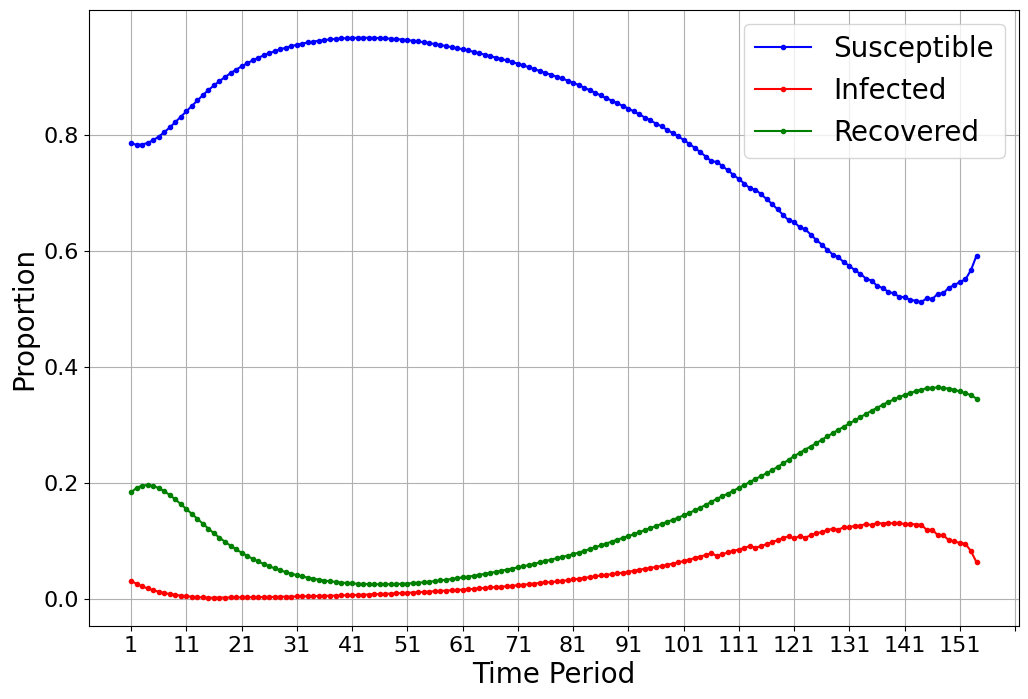

In [12]:
# File paths and folder setup
vaxPath = r"outputData\modModelVax0.1.xlsx"
noVaxPath = r"outputData\modModelNoVax.xlsx"
output_folder = r"diseaseDynamics"
os.makedirs(output_folder, exist_ok=True)

vax = False

# Call the functions for the remaining plots:
#plot_statewide_sirv_comparison(vaxPath, noVaxPath, output_folder)
#plot_cumulative_sirv_dynamics(noVaxPath, output_folder, vax=False)
plot_cumulative_sirv_dynamics(vaxPath, output_folder, vax=False)
#plot_total_infections_comparison(vaxPath, noVaxPath, output_folder)
#plot_total_unmet_demand_comparison(vaxPath, noVaxPath, output_folder)
#plot_combined_sirv_dynamics(vaxPath, output_folder, vax)
#plot_total_sir_comparison(vaxPath, noVaxPath, output_folder)
#plot_county_degree_grids(noVaxPath, output_folder, vax)
